# Assignment 1

## EDA

In [230]:
# Imports
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
from tqdm.notebook import tqdm
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestClassifier
import yake
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [2]:
warnings.simplefilter('ignore')

In [3]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [4]:
def readJSON(path):
    f = gzip.open(path, 'rt', encoding='utf-8')
    f.readline()
    for l in f:
        d = eval(l)
        u = d['userID']
        g = d['gameID']
        yield u,g,d

In [5]:
allHours = []
for l in readJSON("./../data/train.json.gz"):
    allHours.append(l)

In [6]:
hoursTrain = allHours[:165000]
hoursValid = allHours[165000:]
hoursPerUser = defaultdict(list)
hoursPerItem = defaultdict(list)
for u,g,d in hoursTrain:
    r = d['hours_transformed']
    hoursPerUser[u].append((g,r))
    hoursPerItem[g].append((u,r))

In [7]:
# Generate a negative set

userSet = set()
gameSet = set()
playedSet = set()

for u,g,d in allHours:
    userSet.add(u)
    gameSet.add(g)
    playedSet.add((u,g))

lUserSet = list(userSet)
lGameSet = list(gameSet)

notPlayed = set()
for u,g,d in hoursValid:
    #u = random.choice(lUserSet)
    g = random.choice(lGameSet)
    while (u,g) in playedSet or (u,g) in notPlayed:
        g = random.choice(lGameSet)
    notPlayed.add((u,g))

playedValid = set()
for u,g,r in hoursValid:
    playedValid.add((u,g))

In [8]:
def CosineSet(s1, s2):
    # Not a proper implementation, operates on sets so correct for interactions only
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [9]:
# Step 1: Calculate the number of reviews for each game
reviews_count = defaultdict(int)
for _, game_id, _ in allHours:
    reviews_count[game_id] += 1

# Step 2: Determine the threshold for the top 15%
total_games = len(reviews_count)
top_15_threshold = int(0.15 * total_games)

# Step 3: Create the 'popularity' column
popularity_data = []
for _, game_id, _ in allHours:
    popularity = 1 if reviews_count[game_id] > top_15_threshold else 0
    popularity_data.append(popularity)
    
df = pd.DataFrame(allHours, columns=['userID', 'gameID', 'attributes'])
df['popularity'] = popularity_data

In [192]:
# Cosine
correct = 0
p0, p1 = 0, 0

# Assuming hoursPerUser and hoursPerItem are defined as described in your code

for (label, sample) in tqdm([(1, playedValid), (0, notPlayed)]):
    for (u, g) in tqdm(sample):
        maxSim = 0
        users = set(hoursPerItem[g])
        for g2, _ in hoursPerUser[u]:
            sim = CosineSet(users, set(hoursPerItem[g2]))
            if sim > maxSim:
                maxSim = sim
        pred = 0
        if maxSim > 0.025 or len(hoursPerItem[g]) > 60:
            pred = 1
            p1 += 1
        else:
            p0 += 1
        if pred == label:
            correct += 1

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

In [11]:
correct / (len(playedValid) + len(notPlayed))

0.6963196319631964

In [195]:
# Cosine on gradescope
predictions = open("predictions_Played.csv", 'w')
for l in tqdm(open("./../data/pairs_Played.csv"), total=20000):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    maxSim = 0
    users = set(hoursPerItem[g])
    for g2, _ in hoursPerUser[u]:
        sim = CosineSet(users, set(hoursPerItem[g2]))
        if sim > maxSim:
            maxSim = sim
    pred = 0
    if maxSim > 0.025 or len(hoursPerItem[g]) > 60:
        pred = 1
    predictions.write(u + ',' + g + ',' + str(pred) + '\n')
predictions.close()

0it [00:00, ?it/s]

In [12]:
# Cos with another pop feat
correct = 0
p0, p1 = 0, 0
for (label, sample) in tqdm([(1, playedValid), (0, notPlayed)]):
    for (u, g) in tqdm(sample):
        maxSim = 0
        users = set(hoursPerItem[g])
        for g2, _ in hoursPerUser[u]:
            sim = CosineSet(users, set(hoursPerItem[g2]))
            if sim > maxSim:
                maxSim = sim
        # Check if the game is in the top 15% of popularity
        is_popular = df[df['gameID'] == g]['popularity'].values[0]
        pred = 0
        if (maxSim > 0.025 or len(hoursPerItem[g]) > 60) or is_popular:
            pred = 1
            p1 += 1
        else:
            p0 += 1
        if pred == label:
            correct += 1

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

In [13]:
correct / (len(playedValid) + len(notPlayed))

0.6963196319631964

In [14]:
# Baseline

correct = 0
p0, p1 = 0,0
for (label,sample) in [(1, playedValid), (0, notPlayed)]:
    for (u,g) in tqdm(sample):
        maxSim = 0
        users = set(hoursPerItem[g])
        for g2,_ in hoursPerUser[u]:
            sim = Jaccard(users,set(hoursPerItem[g2]))
            if sim > maxSim:
                maxSim = sim
        pred = 0
        if maxSim > 0.025 or len(hoursPerItem[g]) > 62:
            pred = 1
            p1 += 1
        else:
            p0 += 1
        if pred == label:
            correct += 1

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

In [15]:
correct / (len(playedValid) + len(notPlayed))

0.7022702270227023

In [250]:
# HW3 baseline gradescope
sims = []
predictions = open("predictions_Played.csv", 'w')
for l in tqdm(open("./../data/pairs_Played.csv"), total=20000):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    maxSim = 0
    users = set(hoursPerItem[g])
    for g2,_ in hoursPerUser[u]:
        sim = Jaccard(users,set(hoursPerItem[g2]))
        if sim > maxSim:
            maxSim = sim

    try:
        user_topics = set(df_users.loc[u]['topic'])
        game_topics = set(df_games.loc[g]['topic'])
        topic_sim = Jaccard(user_topics,game_topics)
        sims.append(topic_sim)
    except KeyError as e:
        topic_sim = 0
    pred = 0
    if (maxSim > 0.19 or len(hoursPerItem[g]) > 62 or topic_sim > 0.4) or (maxSim > 0.13 and topic_sim > 0.3):
        pred = 1
    predictions.write(u + ',' + g + ',' + str(pred) + '\n')
predictions.close()


  0%|          | 0/20000 [00:00<?, ?it/s]

(array([2.316e+03, 0.000e+00, 9.273e+03, 4.400e+01, 0.000e+00, 5.636e+03,
        2.000e+00, 0.000e+00, 2.023e+03, 0.000e+00, 1.000e+00, 5.760e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 1.090e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 1.600e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00]),
 array([0.        , 0.02153846, 0.04307692, 0.06461538, 0.08615385,
        0.10769231, 0.12923077, 0.15076923, 0.17230769, 0.19384615,
        0.21538462, 0.23692308, 0.25846154, 0.28      , 0.30153846,
        0.32307692, 0.34461538, 0.36615385, 0.38769231, 0.40923077,
        0.43076923, 0.45230769, 0.47384615, 0.49538462, 0.51692308,
        0.53846154]),
 <BarContainer object of 25 artists>)

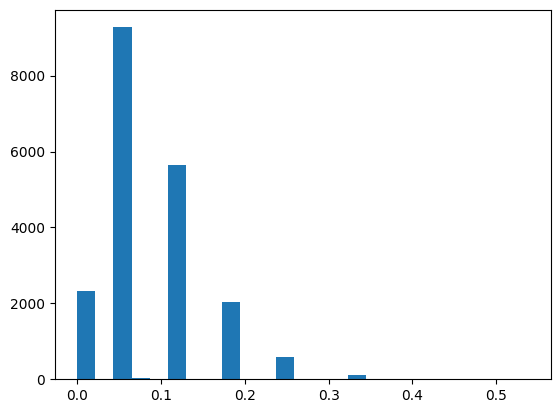

In [240]:
plt.hist(sims, bins=25)

In [208]:
df_users

,game_count,avg_hours,topic
userID,,,
u00003792,15,82.784615,"[game, Great Final Fantasy, sit in queue, good..."
u00011135,24,90.708696,"[game, SCORE, Games, FIre Emblem, good, good g..."
u00054243,13,173.738462,"[game, Vaas Montenegro, games, Montenegro, puz..."
u00121183,12,215.925000,"[kill me URRRRGGGHHHHH, game, Wonderful game, ..."
u00127102,21,3.525000,"[game, knew a guns, fun, enjoyed, playing, pla..."
...,...,...,...
u99899518,40,16.456410,"[aaa aaaa good, aaa aaaa, aaaa good, aaa, good..."
u99916612,16,12.056250,[dadsa]
u99921366,36,110.978788,[]


In [207]:
df_games

,count,avg_hours,topic
gameID,,,
g00045539,26,14.469231,"[game, ships, ship, Fun game, play, space, gre..."
g00083675,107,10.363636,"[game, boss fights, boss, Jotun, Norse mytholo..."
g00087199,51,25.593617,"[game, Cry, Cry game, Cry games, good game, gr..."
g00102027,23,46.834783,"[game, puzzle game, LIMBO, puzzles, games, goo..."
g00125299,91,8.377108,"[DLC DLC DLC, DLC DLC, DLC, game, guns, DLC SI..."
...,...,...,...
g99701966,78,34.962857,"[make, game, Stopped my depression, program, c..."
g99758692,116,14.943269,"[Game, gems, fun, games, hero, hours, trade ho..."
g99811345,29,21.370370,"[GAME, GAME STOP, space, random things put, fi..."


## Feature Engineering (Games and Users)

In [149]:
df = pd.DataFrame(list(map(lambda x: x[2], allHours)))
df.head(3)

,userID,early_access,hours,hours_transformed,found_funny,text,gameID,user_id,date,compensation
0,u70666506,False,63.5,6.011227,1.0,If you want to sit in queue for 10-20min and h...,g49368897,76561198030408772,2017-05-20,NaN
1,u18612571,False,0.2,0.263034,NaN,I was really not a fan of the gameplay. Games ...,g73495588,NaN,2017-01-27,NaN
2,u34283088,False,11.9,3.689299,NaN,Vaas Montenegro is the reason why you should g...,g68047320,76561198057482188,2014-03-06,NaN


In [150]:
kw_extractor = yake.KeywordExtractor()

In [151]:
df_games = df.groupby('gameID')['date'].count().to_frame().rename(columns={"date": 'count'})
df_games['avg_hours'] = df_train.groupby('gameID')['hours'].mean()
df_games.head(3)

,count,avg_hours
gameID,,
g00045539,26,14.469231
g00083675,107,10.363636
g00087199,51,25.593617


In [152]:
df_users = df.groupby('userID')['date'].count().to_frame().rename(columns={"date": 'game_count'})
df_users['avg_hours'] = df_train.groupby('userID')['hours'].mean()
df_users.head(3)

,game_count,avg_hours
userID,,
u00003792,15,82.784615
u00011135,24,90.708696
u00054243,13,173.738462


In [155]:
# Groupby users and games and append all the texts
user_review_text = defaultdict(list)
game_review_text = defaultdict(list)
for u,g,d in allHours:
    user_review_text[u].append(d['text'])
    game_review_text[g].append(d['text'])

In [156]:
# Obtaining all keywords (Topcis) for all game reviews
game_topics = []
for game in tqdm(game_review_text):
    big_str = ' '.join(game_review_text[game])
    res = kw_extractor.extract_keywords(big_str)
    game_topics.append(list(map(lambda x: x[0], res))[:10])

  0%|          | 0/2437 [00:00<?, ?it/s]

In [157]:
# Obtaining all keywords (Topcis) for all reviews the user wrote
user_topics = []
for user in tqdm(user_review_text):
    big_str = ' '.join(user_review_text[user])
    res = kw_extractor.extract_keywords(big_str)
    user_topics.append(list(map(lambda x: x[0], res))[:10])

  0%|          | 0/6710 [00:00<?, ?it/s]

In [158]:
# Adding the extracted topics for the users and games
df_users['topic'] = user_topics
df_games['topic'] = game_topics

In [159]:
# Calculating Jaccard Sims for similar users (in terms of hours)
jaccard_sim = []
i = 0
for i,row in tqdm(df_combined.iterrows(), total=df_combined.shape[0]):
    maxSim = 0
    user, game = row['userID'], row['gameID']
    users = set(hoursPerItem[game])
    for g2,_ in hoursPerUser[user]:
        sim = Jaccard(users,set(hoursPerItem[g2]))
        if sim > maxSim:
            maxSim = sim
    jaccard_sim.append(maxSim)

  0%|          | 0/330000 [00:00<?, ?it/s]

In [160]:
# Add jaccard hour and popular game metrics
popular_game = df_games['count'] > 60
df_combined['jaccard_hours'] = jaccard_sim
df_combined['popular_game'] = df_combined['gameID'].transform(lambda x: popular_game[x])

In [161]:
df_combined

,userID,gameID,played,jaccard_hours,popular_game
0,u96212744,g97744219,1,1.000000,True
1,u71367785,g65794132,0,0.000000,True
2,u17345793,g82616432,0,0.002008,True
3,u31964465,g53562227,1,1.000000,False
4,u41981227,g33872505,1,1.000000,True
...,...,...,...,...,...
329995,u77655643,g53204660,0,0.000000,False
329996,u15676620,g17702591,0,0.000000,True
329997,u24181782,g70898962,0,0.003731,True
329998,u37836993,g14055591,0,0.000000,False


## Creating datasets

In [164]:
train, test = train_test_split(df_combined, test_size=0.2)

In [18]:
df_played = df_train[['userID', 'gameID']]
df_played['played'] = 1

In [19]:
# Create non existing
existing_pairs = set(zip(df_played['userID'], df_played['gameID']))
df_not_played = pd.DataFrame(columns=['userID', 'gameID', 'played'])

for i in tqdm(range(len(df_played))):
    user, game, _ = df_played.iloc[i]
    not_played_game = None
    while not not_played_game or (user, not_played_game) in existing_pairs:
        not_played_game = np.random.choice(df_played['gameID'])
    df_not_played = df_not_played.append({'userID': user, 'gameID': not_played_game, 'played': 0}, ignore_index=True)

  0%|          | 0/165000 [00:00<?, ?it/s]

In [20]:
# Combining
df_combined = pd.concat([df_played, df_not_played])
df_combined = df_combined.sample(frac=1).reset_index(drop=True)
df_combined.head(3)

,userID,gameID,played
0,u96212744,g97744219,1
1,u71367785,g65794132,0
2,u17345793,g82616432,0


## Model Stuff

In [175]:
df_combined

,userID,gameID,played,jaccard_hours,popular_game
0,u96212744,g97744219,1,1.000000,True
1,u71367785,g65794132,0,0.000000,True
2,u17345793,g82616432,0,0.002008,True
3,u31964465,g53562227,1,1.000000,False
4,u41981227,g33872505,1,1.000000,True
...,...,...,...,...,...
329995,u77655643,g53204660,0,0.000000,False
329996,u15676620,g17702591,0,0.000000,True
329997,u24181782,g70898962,0,0.003731,True
329998,u37836993,g14055591,0,0.000000,False


In [167]:
X_train, y_train = train[['jaccard_hours', 'popular_game']], train['played'].astype(bool)
X_test, y_test = test[['jaccard_hours', 'popular_game']], test['played'].astype(bool)

In [185]:
rfc = RandomForestClassifier(max_depth=3)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=3)

In [186]:
y_pred = rfc.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 1.0


In [187]:
# 1. We loop through validation set
# 2. Check if item is in training data else flip coin
# 3. Calculate Features
#    a. Calculate Jaccard between hours of the game and hours of the user
#    b. Calculate if there are more than 60 peeps that reviewed the game
#    c. Calculate jaccard between user topics and game topics
#    d. Calculate average text length of the game
# 4. Pass in calculated features into RFC

In [191]:
predictions = open("predictions_Played.csv", 'w')
for l in tqdm(open("./../data/pairs_Played.csv"), total=10000):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    
    # Obtain game information
    # - jacard
    users = set(hoursPerItem[g])
    for g2,_ in hoursPerUser[u]:
        sim = Jaccard(users,set(hoursPerItem[g2]))
        if sim > maxSim:
            maxSim = sim
    # - popularity
    print(maxSim)
    pop = df_games.loc[g]['count'] > 60
    pred = rfc.predict([[maxSim, pop]])
    print(pred[0])
    
    # Write pred
    predictions.write(u + ',' + g + f",{1 if pred[0] else 0}\n")

predictions.close()

  0%|          | 0/10000 [00:00<?, ?it/s]

0
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.003937007874015748
False
0.00425531914893617
False
0.00425531914893617
False
0.00425531914893617
False
0.008333333333333333
False
0.008333333333333333
False
0.008333333333333333
False
0.008333333333333333
False
0.008333333333333333
False
0.008333333333333333
Fa

False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.02564102564102564
False
0.0256

False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.0357

False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.0357

False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.03571428571428571
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512820512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512820512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512820512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512820512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512820512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.05128205128205128
False
0.0512

KeyboardInterrupt: 

In [178]:
df_games.loc['g26732871']

count                                                      422
avg_hours                                            40.458333
topic        [Scaletta Vito Scaletta, Vito Scaletta Vito, V...
Name: g26732871, dtype: object

In [220]:

correct = 0
p0, p1 = 0,0
for (label,sample) in [(1, playedValid), (0, notPlayed)]:
    for (u,g) in tqdm(sample):
        maxSim = 0
        users = set(hoursPerItem[g])
        for g2,_ in hoursPerUser[u]:
            sim = Jaccard(users,set(hoursPerItem[g2]))
            if sim > maxSim:
                maxSim = sim
        pred = 0
        print(maxSim) 
        break
        if (maxSim > 0.025 or len(hoursPerItem[g]) > 60) or (maxSim > 0.19):
            pred = 1
            p1 += 1
        else:
            p0 += 1
        if pred == label:
            correct += 1

  0%|          | 0/9999 [00:00<?, ?it/s]

0.002890173410404624


  0%|          | 0/9999 [00:00<?, ?it/s]

0
